# Titanic Dataset Preprocessing


First of all let's import basic libraries to load, edit and visualize the dataset

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now lets load the csv file for the training and test set.

In [19]:
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here we can see that we have many categorical features and some numeric ones too. Before turning this dataset into vectors of numbers that our classification algorithms can use, we should deal with missing values.
Let's check how many missing values has our dataset per feature.

In [20]:
training_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
test_set.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We could delete the training samples that have NaN values but in this case we dont have a huge dataset.
First we are going to transform the Cabin feature into a Deck feature, each cabin starts with a letter that denotes the deck and we dont really need more information than that.

In [22]:
# make a list of all the posible Decks, the last element is used when no cabin code is present
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
#define a function that replaces the cabin code with the deck character
def search_substring(big_string, substring_list):
    for substring in substring_list:
        if substring in big_string:
            return substring
    return substring_list[-1]

We have a similar problem with the Name feature, we have too much information that is hard to encode and nt useful. So we can take only the title of the name for each person, lets define a function for that.

In [23]:
# replace passenger's name with his/her title (Mr, Mrs, Miss, Master)
def get_title(string):
    import re
    mrRegex = re.compile(r'Mr|Don Major|Capt|Jonkheer|Rev|Col|Dr', re.IGNORECASE)
    mrsRegex = re.compile(r'Mrs|Countess|Mme', re.IGNORECASE)
    missRegex = re.compile(r'Miss|Mlle|Ms', re.IGNORECASE)
    masterRegex = re.compile(r'Master', re.IGNORECASE)
    if mrRegex.search(string) != None:
        return('Mr')
    elif mrsRegex.search(string) != None:
        return('Mrs')
    elif missRegex.search(string) != None:
        return('Miss')
    elif masterRegex.search(string) != None:
        return('Master')
    else:
        return(str(np.nan))

Now that we have the functions we need, lets apply them and create the features Title and Deck

In [24]:
training_set['Deck'] = training_set['Cabin'].map(lambda x: search_substring(str(x), cabin_list))
test_set['Deck'] = test_set['Cabin'].map(lambda x: search_substring(str(x), cabin_list))
# delete the Cabin feature
training_set.drop('Cabin', 1, inplace=True)
test_set.drop('Cabin', 1, inplace=True)

training_set['Title'] = training_set['Name'].apply(get_title)
test_set['Title'] = test_set['Name'].apply(get_title)
# delete the Name feature
training_set.drop('Name', 1, inplace=True)
test_set.drop('Name', 1, inplace=True)

Let's take a look at the results we got

In [25]:
training_set.tail()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
886,887,0,2,male,27.0,0,0,211536,13.00,S,Unknown,Mr
887,888,1,1,female,19.0,0,0,112053,30.00,S,B,Miss
888,889,0,3,female,NaN,1,2,W./C. 6607,23.45,S,Unknown,Miss
889,890,1,1,male,26.0,0,0,111369,30.00,C,C,Mr
890,891,0,3,male,32.0,0,0,370376,7.75,Q,Unknown,Mr


Now we will drop the Ticket feature that does not really give much insight.

In [26]:
#dropping ticket column
training_set.drop('Ticket', 1, inplace=True)
test_set.drop('Ticket', 1, inplace=True)

We have to do something about the NaN values in the Age column. We can replace them with the mean of the age, but that would mean that some kid (Master or Miss) would appear to be older than they are. So we will take the mean of the age from each Title, and then replace each NaN value with the mean of the age of the corresponding persons title.

In [27]:
means_title = training_set.groupby('Title')['Age'].mean()

In [28]:
title_list = ['Mr','Miss','Mrs','Master']
def age_nan_replace(means, dframe, title_list):
    for title in title_list:
        temp = dframe['Title'] == title #extract indices of samples with same title
        dframe.loc[temp, 'Age'] = dframe.loc[temp, 'Age'].fillna(means[title]) # replace nan values for mean
        

age_nan_replace(means_title, training_set, title_list)
age_nan_replace(means_title, test_set, title_list)

Now lets fill those two NaN cases in the Embarked column.

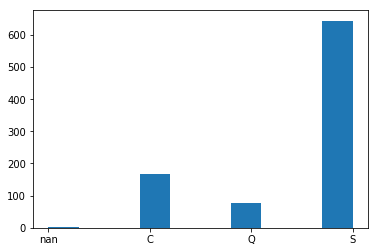

In [29]:
plt.hist(training_set['Embarked'])
plt.show()

We will assgn them the letter S which is the most common case.

In [30]:
training_set['Embarked'].fillna('S', inplace=True)
test_set['Embarked'].fillna('S', inplace=True)
#fill the fare column in the test set
test_set['Fare'].fillna(test_set['Fare'].mean(), inplace=True)

In [31]:
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Unknown,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,C,Mr
2,3,1,3,female,26.0,0,0,7.9250,S,Unknown,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,C,Mr
4,5,0,3,male,35.0,0,0,8.0500,S,Unknown,Mr


We are finished cleaning the dataset, now we have to encode some categorical features and standardize some numerical classes.
Let's standardize the fare and age columns

In [32]:
from sklearn.preprocessing import StandardScaler

numericals_list = ['Age','Fare']
for column in numericals_list:
    sc = StandardScaler(with_mean=True, with_std=True)
#    print(training_set[column].size)
#    print(test_set[column].size)
    sc.fit(training_set[column].values.reshape(-1,1))
    training_set[column] = sc.transform(training_set[column].values.reshape(-1,1))
    test_set[column] = sc.transform(test_set[column].values.reshape(-1,1))


Now let's encode categorical classes with sklearn's LabelEncoder

In [33]:
from sklearn.preprocessing import LabelEncoder
categorical_classes_list = ['Sex','Embarked','Deck', 'Title'] #Pclass is already encoded
#encode features that are cateorical classes
encoding_list = []
for column in categorical_classes_list:
    le = LabelEncoder()
    le.fit(training_set[column])
    encoding_list.append(training_set[column].unique())
    encoding_list.append(list(le.transform(training_set[column].unique())))
    training_set[column] = le.transform(training_set[column])
    test_set[column] = le.transform(test_set[column])


Let's see the results!

In [34]:
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,1,0,3,1,-0.588587,1,0,-0.502445,2,8,2
1,2,1,1,0,0.617097,1,0,0.786845,0,2,2
2,3,1,3,0,-0.287166,0,0,-0.488854,2,8,1
3,4,1,1,0,0.391031,1,0,0.420730,2,2,2
4,5,0,3,1,0.391031,0,0,-0.486337,2,8,2


Feature Engineering:
Let's visualize some aspects of the data so that we can understand what are the most important factors that determined survival.

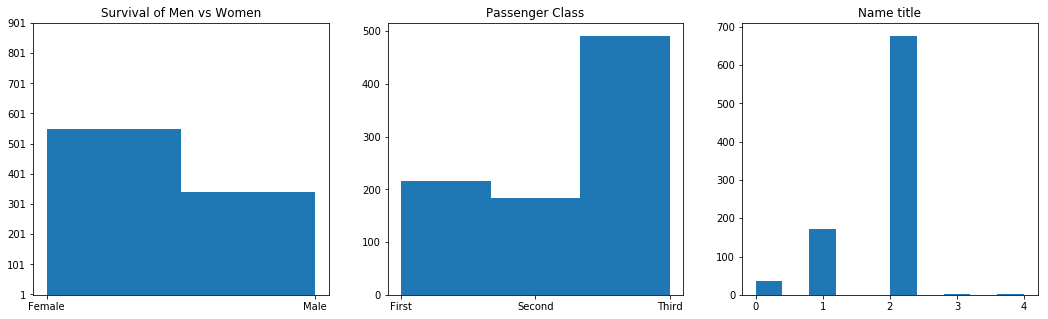

In [35]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(131)
plt.hist(training_set['Survived'], 2)
plt.title('Survival of Men vs Women')
ax.xaxis.set_ticks([0,1])
ax.set_xticklabels(['Female', 'Male'])
ax.yaxis.set_ticks(np.arange(1,1001,100))

ax = plt.subplot(132)
plt.hist(training_set['Pclass'],3)
plt.title('Passenger Class')
ax.xaxis.set_ticks(np.arange(1,4,1))
ax.xaxis.set_ticklabels(['C','Q','S'])
ax.legend()

ax = plt.subplot(133)
plt.hist(training_set['Title'])
plt.title('Name title')
ax.xaxis.set_ticks(np.arange(0,5,1))
ax.xaxis.set_ticklabels(['Master','Miss','Mr','Mrs','NaN'])
ax.legend()
plt.show()

In [36]:
print(encoding_list)

[array(['male', 'female'], dtype=object), [1, 0], array(['S', 'C', 'Q'], dtype=object), [2, 0, 1], array(['Unknown', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object), [8, 2, 4, 6, 3, 0, 1, 5, 7], array(['Mr', 'Miss', 'Master', 'nan', 'Mrs'], dtype=object), [2, 1, 0, 4, 3]]


NameError: name 'label_list' is not defined